In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE  # imblearn library can be installed using pip install imblearn
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, confusion_matrix

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Read the CSV file
df = pd.read_csv(r"C:\Users\ragha\Desktop\Attack_Dataset.csv")

# Drop rows with missing 'class' values
df = df.dropna(subset=['class'])

# Display network traffic data
print('====Network Traffic Data====')
df_data = df.drop(['class'], axis=1)
print(df_data)

# Display attack types and their counts
print('====Attack Types====')
attack_counts = df['class'].value_counts()
print(attack_counts)

pd.set_option('display.max_columns', None) # to make sure you can see all the columns in output window
print(df.head())
print(df.shape)
print(df.info())
print(df.describe())

====Network Traffic Data====
       Duration protocol_type   service flag     src_bytes   dst_bytes  \
0           0.0           tcp  ftp_data   SF  0.000000e+00    1.000000   
1           0.0           tcp     other   SF  6.984920e-10    1.999703   
2           0.0           tcp   private   S0  9.313230e-10    2.999391   
3           0.0          icmp      http   SF  9.313230e-10    3.998836   
4           0.0           tcp      http   SF  6.984920e-10    4.997946   
...         ...           ...       ...  ...           ...         ...   
39994       0.0           tcp     other   SF  1.871750e+05  696.470071   
39995       0.0           tcp      http   SF  1.868004e+05  697.293303   
39996       0.0           tcp      smtp   SF  1.864270e+05  698.022325   
39997       0.0           tcp     eco_i   SF  1.860549e+05  698.843779   
39998       0.0           tcp      http   S0  1.856840e+05  699.611335   

              land  wrong_fragment       urgent          hot  ...  \
0      1514.0

In [3]:
# Converting Categorical features into Numerical features
df['class'] = df['class'].map({'normal':0, 'anomaly':1})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39999 entries, 0 to 39998
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Duration                     39999 non-null  float64
 1   protocol_type                39999 non-null  object 
 2   service                      39999 non-null  object 
 3   flag                         39999 non-null  object 
 4   src_bytes                    39999 non-null  float64
 5   dst_bytes                    39999 non-null  float64
 6   land                         39999 non-null  float64
 7   wrong_fragment               39999 non-null  float64
 8   urgent                       39999 non-null  float64
 9   hot                          39999 non-null  float64
 10  num_failed_logins            39999 non-null  float64
 11  logged_in                    39999 non-null  float64
 12  num_compromised              39999 non-null  float64
 13  root_shell      

In [4]:
#DataFrame is named 'df'
categorical_features = ['service', 'flag', 'protocol_type']
final_data = pd.get_dummies(df, columns=categorical_features, drop_first=True)  # Use drop_first=True to avoid multicollinearity
print(final_data.info())
print(final_data.head(2))
#DataFrame is named 'df'
print(df.dtypes)
#DataFrame is named 'df'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39999 entries, 0 to 39998
Columns: 116 entries, Duration to protocol_type_udp
dtypes: float64(38), object(1), uint8(77)
memory usage: 15.1+ MB
None
   Duration     src_bytes  dst_bytes    land  wrong_fragment    urgent  \
0       0.0  0.000000e+00   1.000000  1514.0    0.000000e+00  1.000000   
1       0.0  6.984920e-10   1.999703  1294.0    2.328310e-10  1.999901   

      hot  num_failed_logins  logged_in  num_compromised  root_shell  \
0  1514.0       0.000000e+00    1.00000           1514.0         0.0   
1  1294.0       6.984920e-10    1.99999           1294.0         0.0   

   su_attempted  num_root  num_file_creations  num_shells  num_access_files  \
0      1.000000    1514.0                 0.0    1.000000            1514.0   
1      1.999999    1294.0                 0.0    1.999505            1294.0   

   num_outbound_cmds  is_host_login  is_guest_login         count  srv_count  \
0       0.000000e+00       1.000000         

In [5]:
# Dividing dataset into label and feature sets
X = final_data.drop('class', axis = 1) # Features
Y = final_data['class'] # Labels
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(39999, 115)
(39999,)


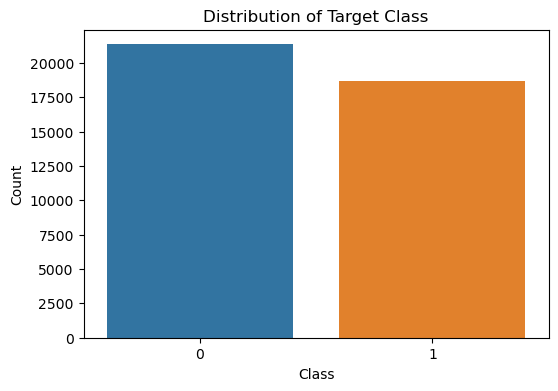

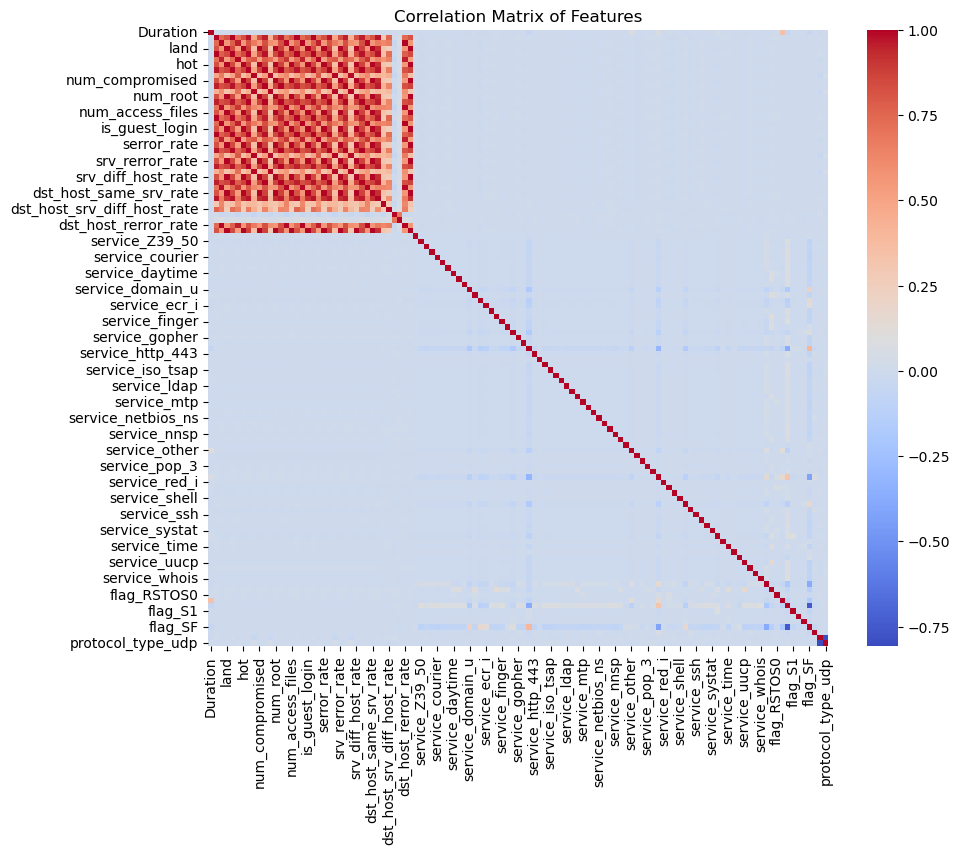

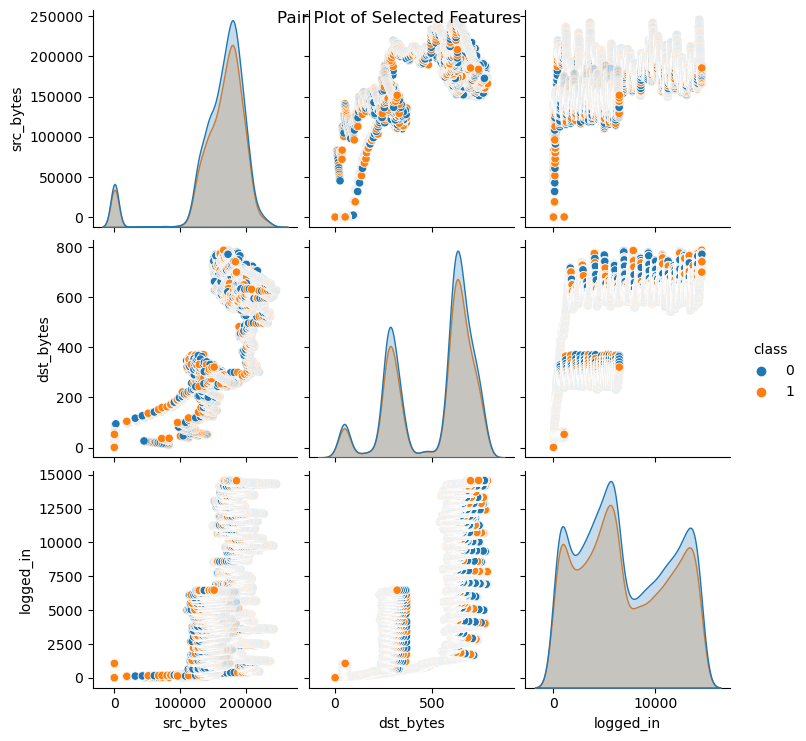

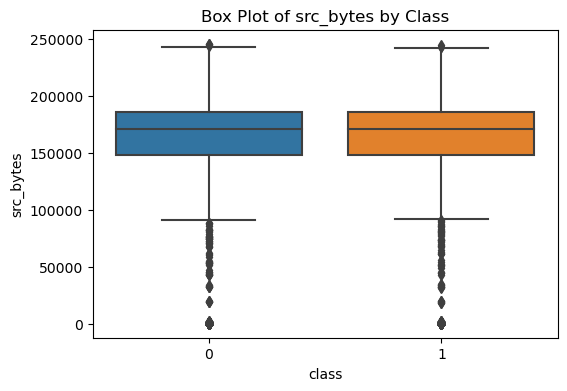

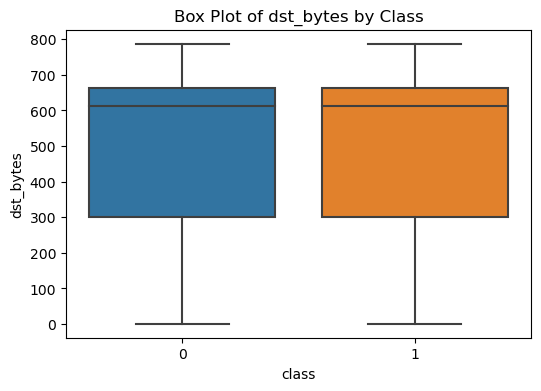

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target class
plt.figure(figsize=(6, 4))
sns.countplot(data=final_data, x='class')
plt.title('Distribution of Target Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualize the correlation matrix of features
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Features')
plt.show()

# Visualize a pair plot of selected features
sns.pairplot(data=final_data, vars=['src_bytes', 'dst_bytes', 'logged_in'], hue='class')
plt.suptitle('Pair Plot of Selected Features')
plt.show()

# Visualize box plots of some features by class
features_to_plot = ['src_bytes', 'dst_bytes']
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=final_data, x='class', y=feature)
    plt.title(f'Box Plot of {feature} by Class')
    plt.show()

In [18]:
# Normalizing numerical features so that each feature has mean 0 and variance 1
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

In [19]:
# Implementing Random Forest Classifier
# Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
model = Pipeline([
        ('balancing', SMOTE(random_state = 101)),
        ('classification', RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=1) )
    ])
grid_param = {'classification__n_estimators': [10,20,30,40,50,100]}

gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring='recall', cv=5)

In [20]:
"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_scaled, Y)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

featimp = pd.Series(gd_sr.best_estimator_.named_steps["classification"].feature_importances_, index=list(X)).sort_values(ascending=False) # Getting feature importances list for the best model
print(featimp)

{'classification__n_estimators': 100}
0.9536390595523212
flag_SF               0.210035
service_http          0.154140
flag_S0               0.151278
service_private       0.060053
service_eco_i         0.043410
                        ...   
service_urh_i         0.000007
service_remote_job    0.000004
service_shell         0.000003
service_printer       0.000000
service_http_8001     0.000000
Length: 115, dtype: float64


In [10]:
# Selecting features with higher sifnificance and redefining feature set
X_ = final_data[['diff_srv_rate','su_attempted','rerror_rate','logged_in']]

feature_scaler = StandardScaler()
X_scaled_ = feature_scaler.fit_transform(X_)

#Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
model = Pipeline([
        ('balancing', SMOTE(random_state = 101)),
        ('classification', RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=1) )
    ])
grid_param = {'classification__n_estimators': [10,20,30,40,50,100]}

gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring='recall', cv=5)

In [11]:
"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_scaled_, Y)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

C:\Users\ragha\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ragha\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ragha\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

{'classification__n_estimators': 100}
0.41493015538247857


In [8]:
# Implementing Support Vector Classifier
# Tuning the kernel parameter and implementing cross-validation using Grid Search
model = Pipeline([
        ('balancing', SMOTE(random_state = 101)),
        ('classification', SVC(random_state=1) )
    ])
grid_param = {'classification__kernel': ['linear','poly','rbf','sigmoid'], 'classification__C': [0.1,1,10]}

gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring='recall', cv=5)

In [9]:
"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_scaled, Y)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

{'classification__C': 1, 'classification__kernel': 'rbf'}
0.9583022576983835


In [10]:
# Preparing a model for recall score using XGBoost
model = Pipeline([
    ('balancing', SMOTE(random_state=101)),
    ('classification', XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False))
])
grid_param = {'classification__n_estimators': [10, 40, 70, 100, 130], 'classification__learning_rate': [0.01, 0.1, 0.02, 0.2, 0.03, 0.3, 0.04, 0.4, 0.05, 0.5]}

gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring='recall', cv=5)
gd_sr.fit(X_scaled, Y)

C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.p

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('balancing', SMOTE(random_state=101)),
                                       ('classification',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_poli...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classification__learning_rate': [0.01, 0.1, 0.02, 0.2,
                                                           0.03, 0.3, 0.04, 0.4,
                                                           0.05, 0.5],
                         'classification__n_estimators': [10, 40, 70, 100,
                                                          130]},
             scoring='recall')

In [11]:
# Best Parameters with Recall Score
best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_
print(best_result)

{'classification__learning_rate': 0.1, 'classification__n_estimators': 130}
0.959374155241146


In [12]:
# Preparing a model for precision score using XGBoost
model = Pipeline([
    ('balancing', SMOTE(random_state=101)),
    ('classification', XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False))
])
grid_param_pr = {'classification__n_estimators': [40], 'classification__learning_rate': [0.1]}

gd_sr_pr = GridSearchCV(estimator=model, param_grid=grid_param_pr, scoring='precision', cv=5)
gd_sr_pr.fit(X_scaled, Y)

# Best Precision Score
best_result_pr = gd_sr_pr.best_score_
print(best_result_pr)

C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ragha\anaconda3\Lib\site-packages\xgboost\sklearn.p

0.958339261665546
